# Missing Data Imputation Using scikit-learn

# Contents 
- [Why does missing data matter?](#why_missing_matter)
- [What are the options for missing data imputation?](#options)
- [Missing data imputation using scikit-learn](#sklearn)
    - [(0) Prepare data](#prep) 
    - [(1) Mean/median](#mean)
    - [(2) Mode (most frequent category)](#mode)
    - [(3) Arbitrary value](#arbitrary)
    - [(4) KNN imputer](#knn)
    - [(5) Adding Missing Indicator](#indicator)
- [What to use?](#what-do-use)


<a id="why_missing_matter"></a>
# Why does missing data matter? 

If you ever worked on raw data collected from a survey or a sensor that is not cleaned yet, you might have also faced missing data. Let's think about a dataset of age, gender, and height as below. You want to use both age and gender to predict height, but you have some data points that either have only age or only gender. What would you do in this case?

|   | age| gender| height|
|---|----|-------|-------|
|  0|  20|     F |   5'4"|
|  1|  31|     M |   6'1"|
|  2|  40|       |   5'0"|
|  3|    |     M |   5'6"|


When certain fields are missing in observation, you either 1) remove the entire observation or 2) keep the observation and replace the missing values with some estimation. Analyzing with complete data after removing any missing data is called **Complete Case Analysis (CCA)** and replacing missing values with estimation is called **missing data imputation**.

Normally, you don't want to remove the entire observation because the rest of the fields can still be informative. Also, when you have lots of variables that are missing in different observations, the chances are you will have to remove the majority of data points and end up being left with limited data to train a model. Even if you manage to build a model, the model will have to know how to handle missing data in production, otherwise, it will freak out and refuse to make any prediction for new data with a missing field!

Therefore, we would want to perform missing data imputation and this post is about how we can do that in Python.


<a id="options"></a>
# What are the options for missing data imputation?

There are many imputation methods available and each has pros and cons 

1. Univariate methods (use values in one variable) 
    - Numerical
        - mean, median, mode (most frequent value), arbitrary value (out of distribution) 
        - For time series: linear interpolation, last observation carried forward, next observation carried backward
    - Categorical
        - mode (most frequent category), arbitrary value (e.g. "missing" category)
    - Both
        - random value selected from train data separately for each missing data
        

2. Multi-variable methods (use values in other variables as well)
    - KNN
    - Regression
    - Chained equation


3. Adding missing indicator 
    - Adding boolean value to indicate the observation has missing data or not. It is used with one of the above methods. 


Although they are all useful in one way or another, in this post, we will focus on 6 major imputation techniques available in sklearn: mean, median, mode, arbitrary, KNN, adding a missing indicator. I will cover why we choose sklearn for our missing imputation in the next post.



<a id="sklearn"></a>
# Missing data imputation using scikit-learn 

<a id="prep"></a>
## (0) Prepare data

In this post, we will use the trainset from the [house price data from Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The data is preprocessed so that string value `?` is transformed into `NaN`.

In [1]:
import pandas as pd
import numpy as np

# prep dataset 
from sklearn.model_selection import train_test_split

# imputer
from sklearn.impute import SimpleImputer, KNNImputer

# plot for comparison 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('../data/house_price/train.csv', index_col='Id')

df.shape

(1460, 80)

There are 80 columns, where 79 are features and 1 is our target variable `SalePrice`. Let's check how many are numerical and categorical as we will apply different impuation strategies to different data types. `.select_dtypes()` in pandas is a handy way to filter data types.

In [3]:
# numerical columns vs. categorical columns 
num_cols = df.drop('SalePrice', axis=1).select_dtypes('number').columns
cat_cols = df.drop('SalePrice', axis=1).select_dtypes('object').columns

print(f"Number of numerical columns: {len(num_cols)}")
print(f"Number of categorical columns: {len(cat_cols)}")

Number of numerical columns: 36
Number of categorical columns: 43


Next is slitting data. **It is important to split the data into train and test set BEFORE, not after, applying any feature engineering or feature selection steps** in order to avoid data leakage. Data leakage means using information that is not available in production during training which leads to model performance inflation. As we want our model performance score to be as close to the real performance in production as possible, we want to split the data as early as possible even before feature engineering steps. 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis=1), 
                                                    df['SalePrice'], 
                                                    test_size=0.3, 
                                                    random_state=0)

X_train.shape, X_test.shape

((1022, 79), (438, 79))

Now let's check which columns have missing data, `NaN`. `.isna()` will give you True/False indicator of if element is `NaN` and `.mean()` will calculate what perforcentage of True there are in each column. We will filter columns with mean greater than 0, which means there is at least one missing data. 

In [5]:
# number of numerical columns and categorical columns that contain missing data
num_cols_with_na = num_cols[X_train[num_cols].isna().mean() > 0]
cat_cols_with_na = cat_cols[X_train[cat_cols].isna().mean() > 0]

print(f"*** numerical columns that have NaN's ({len(num_cols_with_na)}): \n{num_cols_with_na}\n\n")
print(f"*** categorical columns that have NaN's ({len(cat_cols_with_na)}): \n{cat_cols_with_na}")


*** numerical columns that have NaN's (3): 
Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')


*** categorical columns that have NaN's (16): 
Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')


Let's check which feature has how much missing data. It seems that there are three features (`PoolQC`, `MiscFeature`, `Alley`) that have more than 90% of data missing. In such cases, it might be better to remove the entire feature because they do not provide much information when predicting house price. We could perform feature selection to see if it is worth including them or not. However, it is not the scope of this post, so we will include all of them for now. 

In [6]:
# percentage of missing data in numerical features
X_train[num_cols_with_na].isna().mean().sort_values(ascending=False)

LotFrontage    0.184932
GarageYrBlt    0.052838
MasVnrArea     0.004892
dtype: float64

In [7]:
# percentage of missing data in categorical features
X_train[cat_cols_with_na].isna().mean().sort_values(ascending=False)

PoolQC          0.997065
MiscFeature     0.956947
Alley           0.939335
Fence           0.813112
FireplaceQu     0.467710
GarageCond      0.052838
GarageQual      0.052838
GarageFinish    0.052838
GarageType      0.052838
BsmtFinType2    0.024462
BsmtFinType1    0.023483
BsmtExposure    0.023483
BsmtCond        0.023483
BsmtQual        0.023483
MasVnrType      0.004892
Electrical      0.000978
dtype: float64

<a id="mean"></a>
## (1) Mean/median

First missing data imputation method we will look at is mean/median imputation. As the name implies, it fills missing data with the mean or the median of each variable. 

When should we mean vs median? If the variable is normally distributed, the mean and the median do not differ a lot. However, if the distribution is skewed, the mean is affected by outliers and can deviate a lot from the mean, so the median is a better representationo for skewed data. Therefore, **use the mean for normal distribution and the median for skewed distribution.** 

<div style="text-align:center">
<img src="images/skew_dist.png" alt="drawing" width="300"/>
<figcaption>Fig 1. Skewness 
<a href="https://en.wikipedia.org/wiki/Skewness">(Skewness)</a>
</figcaption>
</div>

### Assumptions 
- Missing data most likely look like the majority of the data 
- Data is missing at random 

### Pros 
- Easy and fast
- Can easily be integrated into production

### Cons 
- It distorts the original variable distribution (more values around the mean will create more outliers)
- It ignores and distorts the correlation with other variables

**A common practice is to use mean/median imputation with combination of 'missing indicator' that we will learn in a later section. This is the top choice in data science competitions**.


Below is how we use the mean/median imputation. **It only works for numerical data**. To make it simple, we used columns with NA's here (`X_train[num_cols_with_na]`).

In [8]:
# initialize imputer. use strategy='median' for median imputation
imputer = SimpleImputer(strategy='mean')

# fit the imputer on X_train. we pass only numeric columns with NA's here.
imputer.fit(X_train[num_cols_with_na])

# transform the data using the fitted imputer
X_train_mean_impute = imputer.transform(X_train[num_cols_with_na])
X_test_mean_impute = imputer.transform(X_test[num_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_mean_impute = pd.DataFrame(X_train_mean_impute, columns=num_cols_with_na)
X_test_mean_impute = pd.DataFrame(X_test_mean_impute, columns=num_cols_with_na)

In [9]:
# check statistics
print("Imputer statistics (mean values):")
print(imputer.statistics_)

Imputer statistics (mean values):
[  69.66866747  103.55358899 1978.01239669]


Previously, we mentioned the mean imputation can distort the original distribution. Let's see how much it changed the data distribution by checking the density plot. 

As you can see in `LotFrontage`, you have a lot more values around the mean after the imputation. The more missing data a variable has, the bigger the distortion is (`LotFrontage` has 18%, `GarageYrBlt` has 5%, and `MasVnrArea` has 0.5% of missing data).

One way to avoid this side effect is to use random data imputation. However, I excluded it from this post as it is not available in sklearn and it is not very production-friendly. It requires the whole populatlion of train data to be available to impute each missing data point.

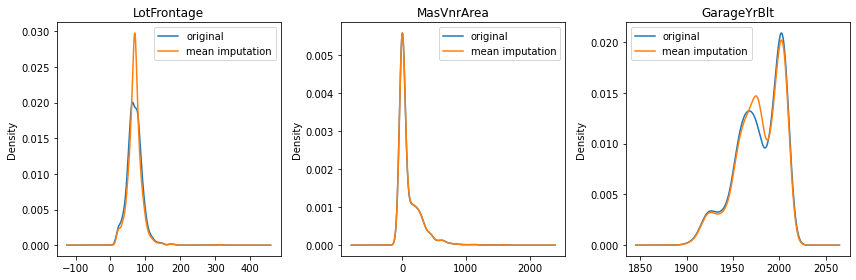

In [10]:
# compare the distribution before/after mean imputation 

fig, axes = plt.subplots(figsize=(12, 4))
for i in range(len(num_cols_with_na)):
    ax = plt.subplot(1, 3, i+1)
    col = num_cols_with_na[i]
    
    X_train[col].plot.kde()
    X_train_mean_impute[col].plot.kde()
    
    ax.set_title(col)
    ax.legend(['original', 'mean imputation'])
plt.tight_layout()

<a id="mode"></a>
## (2) Mode (most frequent category)

The second method is mode imputation. It is replacing missing values with the most frequent value in a variable. **It can be used for both numerical and categorical**. 

### Assumptions 
- Missing data most likely look like the majority of the data
- Data is missing at random 


### Pros 
- Easy and fast
- Can easily be integrated into production

### Cons 
- It distorts the original variable distribution (more values around the mean will create more outliers)
- It ignores and distorts the correlation with other variables
- The most frequent label might be over-represented while it is not the most representative value of a variable


This time, let's try it to our categorical variables. 

In [11]:
# initialize imputer 
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[cat_cols_with_na])

# transform the data using the fitted imputer
X_train_mode_impute = imputer.transform(X_train[cat_cols_with_na])
X_test_mode_impute = imputer.transform(X_test[cat_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_mode_impute = pd.DataFrame(X_train_mode_impute, columns=cat_cols_with_na)
X_test_mode_impute = pd.DataFrame(X_test_mode_impute, columns=cat_cols_with_na)

In [12]:
# check statistics
print("Imputer statistics (the most frequent values in each variable):")
print(imputer.statistics_)

Imputer statistics (the most frequent values in each variable):
['Pave' 'None' 'TA' 'TA' 'No' 'Unf' 'Unf' 'SBrkr' 'Gd' 'Attchd' 'Unf' 'TA'
 'TA' 'Gd' 'MnPrv' 'Shed']


Like the mean/median imputation, mode imputation can also distort the original distribution of a variable. In order to check the difference between before/after the mode imputation, we used bar plot this time as it is for categorical variables. 

Let's take a look at the first variable in the graph, `Alley`. As you can see, the distribution of the original data and that of the imputated data are very different and the `Pave` category is over-represented in the imputed data. Ideally the shape of the distribution should be preserved after imputation just like `MasVnrType`. However, if the majority of the observations is missing, the distribution of a variable can change significantly as does the correlation with other variables.

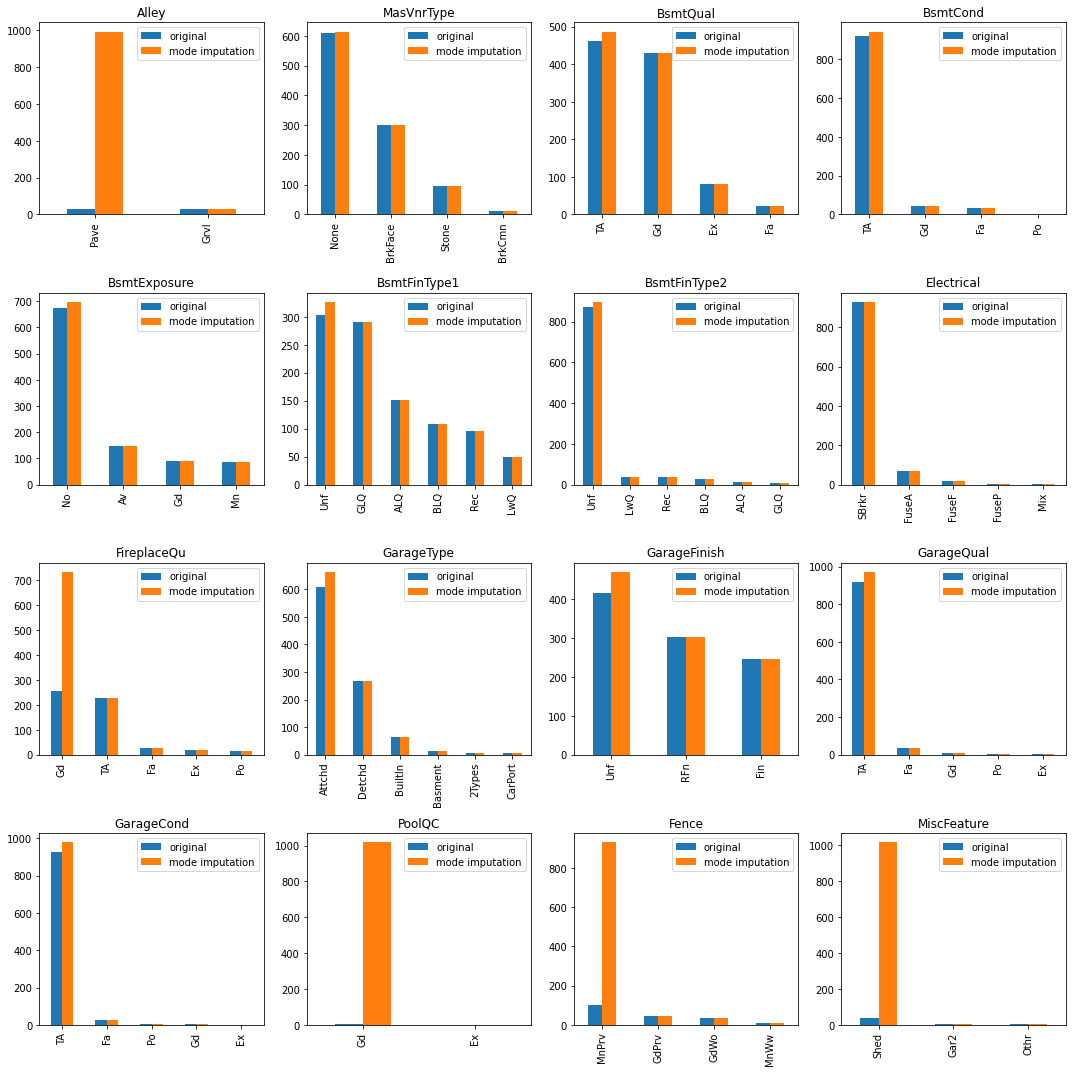

In [13]:
# compare the distribution before/after mode imputation 

fig, axes = plt.subplots(4,4, figsize=(15, 15))

for i in range(len(cat_cols_with_na)):
    col_name = cat_cols_with_na[i]
    original = X_train[col_name].value_counts()
    imputed = X_train_mode_impute[col_name].value_counts()
    combined = pd.concat([original, imputed], keys=['original', 'mode imputation'], axis=1)

    ax = axes[i//4, i%4]
    combined.plot.bar(ax=ax)
    ax.set_title(col_name)
    
plt.tight_layout()

<a id="arbitrary"></a>
##  (3) Arbitrary value

The third method is filling missing values with an arbitrary value outside of the training dataset. For example, if the values in the 'age' variable range from 0 to 80 in the training set, fill missing data with 100 (or using a value at the 'end of distribution' using mean +- 3*std). If categorical data, use 'Missing' as a new category for missing data. It can be counter-intuitive to fill data with a value outside of the original distribution as it will create outliers or unseen data. It indeed is not meant to be used for models that require certain assumptions about data distribution, such as linear regression. It is good for three-based models which will separate missing data in an earlier/upper node and take the missingness into account when building a model. 

### Assumptions
- If data is not missing at random, they would want to flag them with a very different value than other observations and have them treated differently by a model

### Pros
- Easy and fast  
- It captures the importance of 'missingness'

### Cons 
- It distorts the original data distribution 
- It distorts the correlation between variables 
- It may mask or create outliers if numerical variables 
- It is not for linear models. Only use it for tree-based models. 


It can be used for both numerical and categorical and numerical variable is more involved if we need to determine the fill value automatically. 

Let's see how we do for categorical variables first.

### Categorical

Filling missing values with a new category called 'missing' or 'Missing' is a very common strategy for imputing missing data in categorical variable.

In [14]:
# initialize imputer 
imputer = SimpleImputer(strategy='constant', fill_value='Missing')

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[cat_cols_with_na])

# transform the data using the fitted imputer
X_train_arb_impute = imputer.transform(X_train[cat_cols_with_na])
X_test_arb_impute = imputer.transform(X_test[cat_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_arb_impute = pd.DataFrame(X_train_arb_impute, columns=cat_cols_with_na)
X_test_arb_impute = pd.DataFrame(X_test_arb_impute, columns=cat_cols_with_na)

You can see there is now a new category 'Missing' in the imputed dataset.

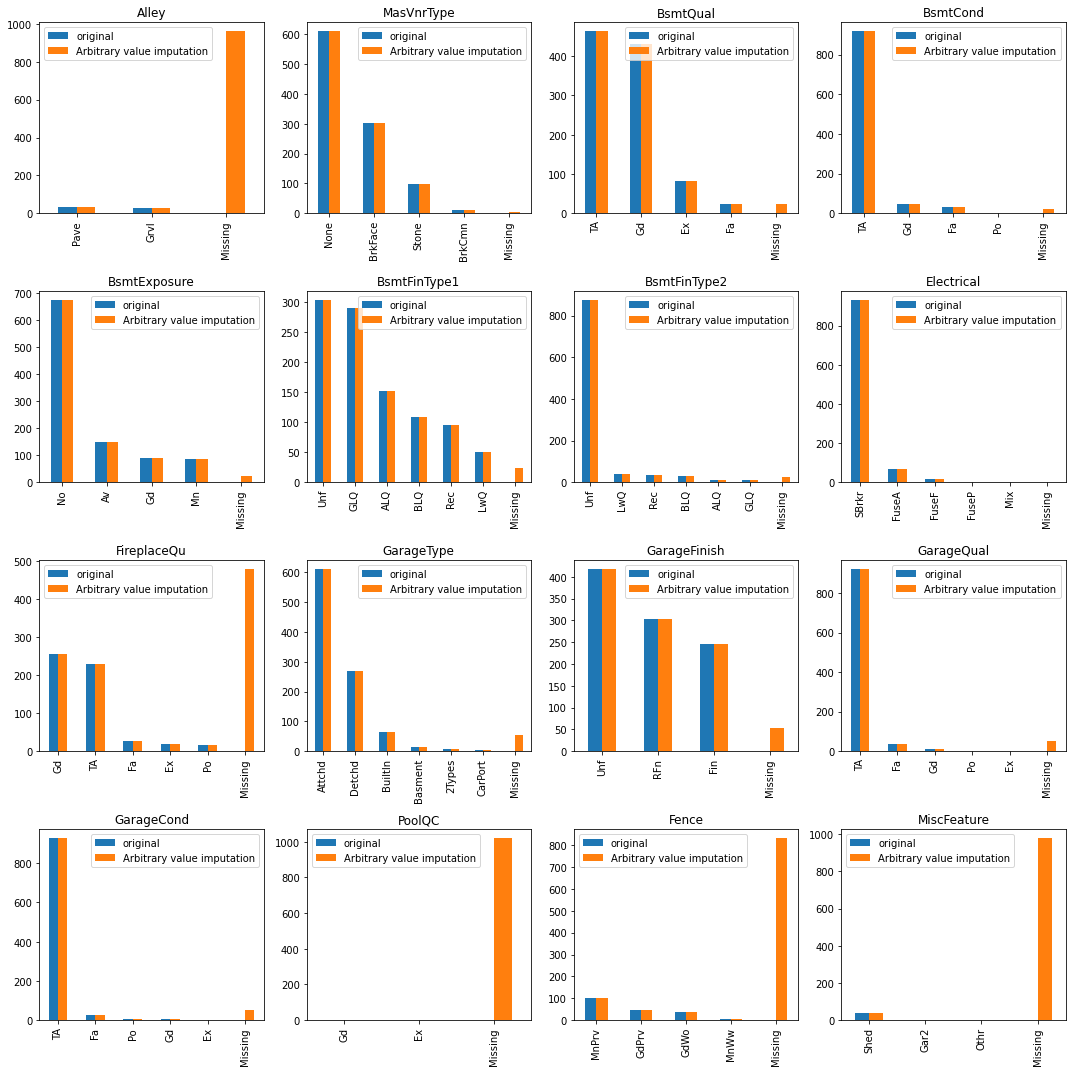

In [15]:
# compare the distribution before/after mode imputation 

fig, axes = plt.subplots(4,4, figsize=(15, 15))

for i in range(len(cat_cols_with_na)):
    col_name = cat_cols_with_na[i]
    original = X_train[col_name].value_counts()
    imputed = X_train_arb_impute[col_name].value_counts()
    combined = pd.concat([original, imputed], 
                         keys=['original', 'Arbitrary value imputation'], 
                         axis=1)

    ax = axes[i//4, i%4]
    combined.plot.bar(ax=ax)
    ax.set_title(col_name)
    
plt.tight_layout()

### Numerical

When determinining what value to use for numerical variables, one way to do is 'end of distribution' method.

For normal distribution: mean $\pm 3\times$ std  
For skewed distribution, use either upper limit or lower limit: 
- Upper limit = 75th quantile + $1.5\times$ IQR
- Lower limit = 25th quantile + $1.5\times$ IQR

where IQR = 75th qualtile - 25th quantile.

Let's check the 

In [16]:
# first find the value to use
def get_end_of_dist(X_train, col):
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3-q1 

    new_val = q3 + iqr * 3
    return new_val

In [17]:
# determine which column to impute 
col = 'LotFrontage'

# initialize imputer 
imputer = SimpleImputer(strategy='constant', fill_value=get_end_of_dist(X_train, col))

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[[col]])

# transform the data using the fitted imputer
X_train_arb_impute = imputer.transform(X_train[[col]])
X_test_arb_impute = imputer.transform(X_test[[col]])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_arb_impute = pd.DataFrame(X_train_arb_impute, columns=[col])
X_test_arb_impute = pd.DataFrame(X_test_arb_impute, columns=[col])

When we check the plot below, we now have a small peak at around 150, which is the value that is determined by our `get_end_of_dist` function. This method definitely distorts the original data distribution and should be used carefully for only appropriate models. 

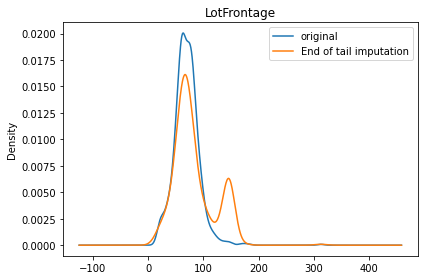

In [18]:
# compare the distribution before/after mean imputation 

fig, ax = plt.subplots()
X_train[col].plot.kde()
X_test_arb_impute[col].plot.kde()

ax.set_title(col)
ax.legend(['original', 'End of tail imputation'])
plt.tight_layout()

<a id="knn"></a>
## (4) KNN imputer

KNN imputer is much more sophisticated and nuanced than the imputation methods described so far because it uses other data points and variables, not just the variable the missing data is coming from. KNN imputer calculates the distance between points (usually based on Eucledean distance) and finds the K closest (=similar) points. And then, estimates the missing value given what other points have for the variable. Note that this can only be used for numerical variables.


### Pros 
- More accurate than univariate imputation
- More likely to preserve the original distribution hence the covariance

### Cons 
- Computationally expensive than univariate imputation 
- Can be sensitive to outliers (quality of other points)

In [19]:
# initialize imputer 
imputer = KNNImputer()

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[num_cols_with_na])

# transform the data using the fitted imputer
X_train_knn_impute = imputer.transform(X_train[num_cols_with_na])
X_test_knn_impute = imputer.transform(X_test[num_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute = pd.DataFrame(X_train_knn_impute, columns=num_cols_with_na)
X_test_knn_impute = imputer.transform(X_test[num_cols_with_na])


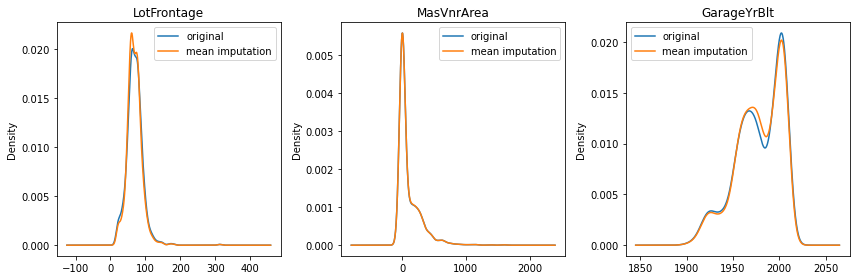

In [20]:
fig, axes = plt.subplots(figsize=(12, 4))
for i in range(len(num_cols_with_na)):
    ax = plt.subplot(1, 3, i+1)
    col = num_cols_with_na[i]
    
    X_train[col].plot.kde()
    X_train_knn_impute[col].plot.kde()
    
    ax.set_title(col)
    ax.legend(['original', 'mean imputation'])
plt.tight_layout()

<a id="indicator"></a>
## (5) Adding Missing Indicator

Adding a binary missing indicator is another common practice when it comes to missing data imputation. This is used with other imputation techniques, such as mean, median, or mode imputation. 

### Assumptions
- Data is not missing at random 
- Missingness provides information 

### Pros
- Eeasy and fast 
- It captures the importance of missingness 

### Cons
- It can expand the feature space pretty quickly if there are a lot of features 



In [21]:
num_cols_with_na.append(num_cols_with_na + '_NA')

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'LotFrontage_NA',
       'MasVnrArea_NA', 'GarageYrBlt_NA'],
      dtype='object')

In [22]:
# initialize imputer 
imputer = KNNImputer(add_indicator=True)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[num_cols_with_na])

# transform the data using the fitted imputer
X_train_knn_impute = imputer.transform(X_train[num_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute = pd.DataFrame(X_train_knn_impute, 
                                  columns=num_cols_with_na.append(num_cols_with_na + '_NA'))

In [23]:
X_train_knn_impute.head()

,LotFrontage,MasVnrArea,GarageYrBlt,LotFrontage_NA,MasVnrArea_NA,GarageYrBlt_NA
0,71.6,573.0,1998.0,1.0,0.0,0.0
1,56.2,0.0,1996.0,1.0,0.0,0.0
2,50.0,0.0,1979.2,0.0,0.0,1.0
3,60.0,0.0,1939.0,0.0,0.0,0.0
4,60.0,0.0,1930.0,0.0,0.0,0.0


<a id="what-do-use"></a>
# What to use?

The obvious question to follow next is then, "What method should we use?" The answer is tricky as there is no hard answer to what the best method is for every case. 

The most commonly used technique, as described above, is using the mean/median imputation with combination of missing data indicator for numerical variables and filling missing data with the new 'Missing' category for categorical variables. 

However, it is wise to still investigate different methods by cross validating different combinations of methods and see which method is most effective to your problem. In the next post, we will learn how to do it with sklearn and why it is useful to use sklearn for imputation rather than normal Pandas functions. 

See you in the next post! 

<a id="References"></a>
# References

- [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/)
- [6 Different Ways to Compensate for Missing Values In a Dataset (Data Imputation with examples)](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)
- [Handle Missing Values in Time Series For Beginners](https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners)
- [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
- [sklearn KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)